(supervised:linear-regression:outliers)=
# Outliers

Data sets almost always contain outliers, that is, samples showing very different behavior compared to most other samples. Outliers may influence regressions results. Thus, we have to cope with them somehow.

One approach is to remove outliers in advance, so they do not take part in the regression process. But how to detect outliers? Exploratory data analysis might expose some outliers. Alternatively we may apply some advanced statistical methods to automatically detect outliers. But such methods are beyond the scope of this lecture series.

Another approach is to modify regression methods in a way which makes them more *robust* to outliers. We will consider two ideas in detail:
* Choose loss functions other than mean squared error.
* Run regression on subsets of the data to find subsets without outliers.

## Example

To illustrate the influence of outliers we consider linear regression for a synthetic data set with one feature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.linear_model as linear_model
import sklearn.metrics as metrics

from numpy.random import default_rng
rng = default_rng(42)

In [2]:
# feature range
xmin = 0
xmax = 1

# true coefficients: y = a * x + b
a = 0.5
b = 1

# parameters of data set
n = 100
noise_level = 0.01
outlier_rate = 0.05
outlier_noise_level = 1

To simulate data with outliers we take exact data, add some Gaussian noise, and then randomly select several data points. The selected data points are moved upwards by some random distance.

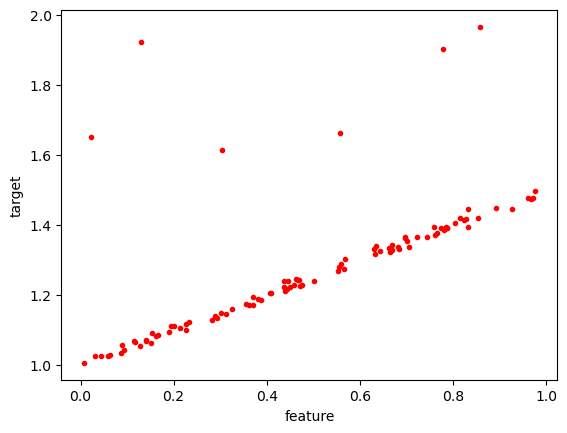

In [3]:
# simulate data without outliers
X = (xmax - xmin) * rng.random((n, 1)) + xmin
y = (a * X + b).reshape(-1) + noise_level * rng.standard_normal(n)

# add some outliers
outlier_mask = rng.choice([True, False], size=y.size, p=[outlier_rate, 1 - outlier_rate])
inlier_mask = np.logical_not(outlier_mask)
y[outlier_mask] = (a * X[outlier_mask, 0] + b).reshape(-1) \
                  + outlier_noise_level * rng.random(np.count_nonzero(outlier_mask))

# plot data
fig, ax = plt.subplots()
ax.plot(X.reshape(-1), y, 'or', markersize=3)
ax.set_xlabel('feature')
ax.set_ylabel('target')
plt.show()

To investigate the influence of outliers we do two regressions: one with outliers removed from the data set and one with the full data set.

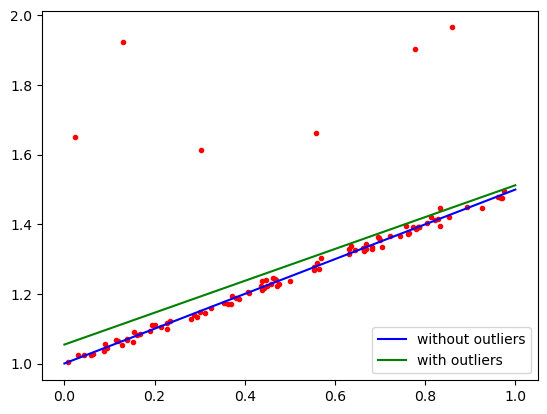

RMSE exact solution:   0.009791289366682039
RMSE without outliers: 0.009790327732097473
RMSE with outliers:    0.03698110315752278


In [4]:
# regression without outliers
reg = linear_model.LinearRegression()
reg.fit(X[inlier_mask, :], y[inlier_mask])

# regression with full data
outreg = linear_model.LinearRegression()
outreg.fit(X, y)

# plot results
fig, ax = plt.subplots()
ax.plot(X.reshape(-1), y, 'or', markersize=3)
ax.plot(
    [xmin, xmax],
    [reg.intercept_ + xmin * reg.coef_[0], reg.intercept_ + xmax * reg.coef_[0]],
    '-b', label='without outliers'
)
ax.plot(
    [xmin, xmax],
    [outreg.intercept_ + xmin * outreg.coef_[0], outreg.intercept_ + xmax * outreg.coef_[0]],
    '-g', label='with outliers')
ax.legend()
plt.show()

# errors
err = metrics.mean_squared_error(y[inlier_mask], reg.predict(X[inlier_mask, :]),
                                 squared=False)
outerr = metrics.mean_squared_error(y[inlier_mask], outreg.predict(X[inlier_mask, :]),
                                    squared=False)
exact_err = metrics.mean_squared_error(y[inlier_mask], a * X[inlier_mask, 0] + b,
                                    squared=False)
print('RMSE exact solution:  ', exact_err)
print('RMSE without outliers:', err)
print('RMSE with outliers:   ', outerr)

We clearly see, that the small number of outliers deteriorate results significantly.

## Loss Functions

We already discussed three different loss functions in [](supervised:general:quality-measures):
* mean squared error (differentiable, sensitive to outliers),
* mean absolut error (non-differentiable, more robust w.r.t. outliers),
* Huber loss (differentiable, more robust w.r.t. to outliers).

If we try to minimize the mean squared error, (large) deviations from outliers get much more penalized than (small) deviations from inliers. In other words, outliers attract the optimal solution much more than inliers. Thus, even few outliers lead to deviations of the minimizing regression line towards the outliers.

MSE is favorable in view of computation time (linear regression requires solving only one system of linear equations). MAE requires very advanced optimization algoritms to solve the linear regression problem. Huber loss is somewhere in between.

### MAE with Scikit-Learn

Scikit-Learn does not implement regression with mean absolute error loss directly. But we may interpret mean absolute error regression as a special case of a more general regression routine: the [`SGDRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html). This is not a regression technique on its own, but a specific algorithm for minimizing a wide class of functionals typically occuring in regression problems. We do not go into the details her, but we only use it to test mean absolute error regression for our simple illustrating example. Take care, that `SGDRegressor` uses gradient based optimization here, which might yield non-optimal results due to non-differentiability.

In [5]:
maereg = linear_model.SGDRegressor('epsilon_insensitive', epsilon=0, alpha=0)
maereg.fit(X, y)

maeerr = metrics.mean_squared_error(y[inlier_mask], maereg.predict(X[inlier_mask, :]),
                                    squared=False)
print('RMSE exact solution:             ', exact_err)
print('RMSE for MSE without outliers:   ', err)
print('RMSE for MSE with outliers:      ', outerr)
print('RMSE for MAE loss with outliers: ', maeerr)

RMSE exact solution:              0.009791289366682039
RMSE for MSE without outliers:    0.009790327732097473
RMSE for MSE with outliers:       0.03698110315752278
RMSE for MAE loss with outliers:  0.009839046162356173


### Huber Loss with Scikit-Learn

For details on linear regression with Huber loss see [Scikit-Learn's User Guide](https://scikit-learn.org/stable/modules/linear_model.html#huber-regression).

Scikit-Learn provides the [`HuberRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html).

In [6]:
huberreg = linear_model.HuberRegressor()
huberreg.fit(X, y)

hubererr = metrics.mean_squared_error(y[inlier_mask], huberreg.predict(X[inlier_mask, :]),
                                    squared=False)
print('RMSE exact solution:               ', exact_err)
print('RMSE for MSE without outliers:     ', err)
print('RMSE for MSE with outliers:        ', outerr)
print('RMSE for MAE loss with outliers:   ', maeerr)
print('RMSE for Huber loss with outliers: ', hubererr)

RMSE exact solution:                0.009791289366682039
RMSE for MSE without outliers:      0.009790327732097473
RMSE for MSE with outliers:         0.03698110315752278
RMSE for MAE loss with outliers:    0.009839046162356173
RMSE for Huber loss with outliers:  0.00980351846505725


## RANSAC Algorithm

If one does not want to change the loss function to lower the influence of outliers, one can apply the RANSAC algorithm to a given regression method. RANSAC is the abbreviation of *random sample consensus*. The idea is to randomly choose a small subset of the data and train the model on this subset. The smaller the subset the higher the chance to have no outliers in the subset. But the subset has to be large enough to determine all model parameters.

In a second step all other data points are compared to corresponding model predictions. If the model provides a good prediction, the data point is considered as inlier. If the prediction if far away from the true target, then the data point is marked as outlier. Here, we have to choose a threshold value to separate inliers from outliers.

If there are too few inliers compared to the size of the data set (and to an estimate of the outlier rate), the model is rejected. Else the model is refit to the whole inlier set and the fitting error is computed.

This process is repeated with different random subsets several times. The model with the lowest fitting error is chosen as final model. Probabilistic considerations suggest up to
\begin{equation*}
\frac{\ln(1-p)}{\ln(1-(1-r)^s)},
\end{equation*}
iterations, where $s$ is the number of data points in the subset, $r\in(0,1)$ is the estimated outlier rate for the full data set, and $p$ is the prescribed probability to have at least one subset containing no outliers. Alternatively, one can prescribe an error level to stop the iteration if the fitting error of a model is below this level.

### Example

To get a better understanding of the algorithm we implement it without using Scikit-Learn routines.

First we set the parameters and calculate the number of iterations required.

In [7]:
estimated_outlier_rate = 0.05    # ~ outlier_rate
threshold_value = 0.04    # ~ noise_level
subset_size = 2    # two points determine a straight line (2 model parameters)
min_inliers = int(0.9 * n)    # reliable lower bound on number of inliers in full data set

max_iter = int(np.log(1 - 0.99) / np.log(1 - (1 - estimated_outlier_rate) ** subset_size))
print('max_iter =', max_iter)

max_iter = 1


In [8]:
max_iter = 10

To be able to investigate each step of the algorithm we store all information about each single iteration.

In [9]:
subset_masks = np.empty((max_iter, n), dtype=bool)    # each row is a mask determining a subset
initial_subset_masks = np.empty((max_iter, n), dtype=bool)    # initial subset used for first fit
errors = np.empty(max_iter)    # MSE for all models
models_a = np.empty(max_iter)    # parameter a for all models
models_b = np.empty(max_iter)    # parameter b for all models
initial_models_a = np.empty(max_iter)    # parameter a for all models (first fit)
initial_models_b = np.empty(max_iter)    # parameter b for all models (first fit)

ordered_mask = np.full(n, False)      # will be shuffled to get a random mask...
ordered_mask[0:subset_size] = True    # ...for subset selection

reg = linear_model.LinearRegression()
best_error = None
best_index = None
best_model = None

for k in range(0, max_iter):
    
    # determine subset
    subset_mask = rng.permutation(ordered_mask)
    initial_subset_masks[k] = subset_mask.copy()
    
    # fit model to subset
    reg.fit(X[subset_mask, :], y[subset_mask])
    initial_models_a[k] = reg.coef_[0]
    initial_models_b[k] = reg.intercept_
    
    # get points supporting the model
    not_mask = np.logical_not(subset_mask)
    subset_mask[not_mask] = (np.abs(reg.predict(X[not_mask, :]) - y[not_mask])
                             <= threshold_value)
    
    # refit model to extended subset
    reg.fit(X[subset_mask, :], y[subset_mask])
    models_a[k] = reg.coef_[0]
    models_b[k] = reg.intercept_
    errors[k] = metrics.mean_squared_error(reg.predict(X[subset_mask, :]), y[subset_mask])
    subset_masks[k, :] = subset_mask

    # find best model
    if np.count_nonzero(subset_mask) >= min_inliers:
        if (best_error == None) or (errors[k] < best_error):
            best_error = errors[k]
            best_index = k
            best_model = reg

The fitting error is very good:

In [10]:
ransacerr = metrics.mean_squared_error(y[inlier_mask], best_model.predict(X[inlier_mask, :]),
                                       squared=False)
print('RMSE exact solution:               ', exact_err)
print('RMSE for MSE without outliers:     ', err)
print('RMSE for MSE with outliers:        ', outerr)
print('RMSE for MAE loss with outliers:   ', maeerr)
print('RMSE for Huber loss with outliers: ', hubererr)
print('RMSE for RANSAC with outliers:     ', ransacerr)

RMSE exact solution:                0.009791289366682039
RMSE for MSE without outliers:      0.009790327732097473
RMSE for MSE with outliers:         0.03698110315752278
RMSE for MAE loss with outliers:    0.009839046162356173
RMSE for Huber loss with outliers:  0.00980351846505725
RMSE for RANSAC with outliers:      0.00980412170408581


Since we have stored all information, we now may plot the fitting procedure for each interation.

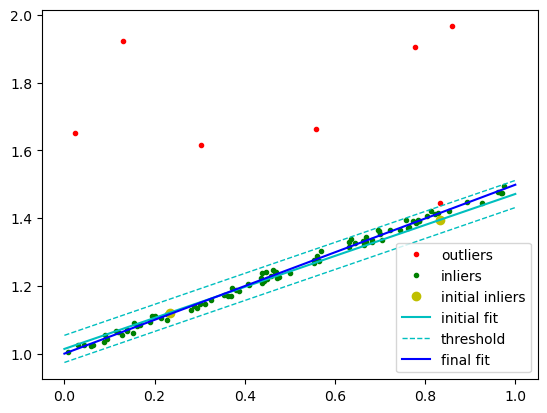

In [11]:
index = best_index

init_mask = initial_subset_masks[index]
mask = subset_masks[index]
not_mask = np.logical_not(mask)
init_a = initial_models_a[index]
init_b = initial_models_b[index]

fig, ax = plt.subplots()

# points not supporting the model
ax.plot(X[not_mask, 0], y[not_mask], 'or', markersize=3, label='outliers')

# points supporting the model
ax.plot(X[mask, 0], y[mask], 'og', markersize=3, label='inliers')

# initial subset
ax.plot(X[init_mask, 0], y[init_mask], 'oy', markersize=6, label='initial inliers')

# initial fit
ax.plot([xmin, xmax], [init_b + xmin * init_a,
                       init_b + xmax * init_a], '-c', label='initial fit')

# treshold value
ax.plot([xmin, xmax], [threshold_value + init_b + xmin * init_a,
                       threshold_value + init_b + xmax * init_a], '--c', label='threshold', linewidth=1)
ax.plot([xmin, xmax], [-threshold_value + init_b + xmin * init_a,
                       -threshold_value + init_b + xmax * init_a], '--c', linewidth=1)

# final fit
ax.plot([xmin, xmax], [models_b[index] + xmin * models_a[index],
                       models_b[index] + xmax * models_a[index]], '-b', label='final fit')

ax.legend()
plt.show()

### RANSAC with Scikit-Learn

Scikit-Learn offers the [`RANSACRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html).

In [12]:
reg = linear_model.RANSACRegressor(linear_model.LinearRegression(),
                                   min_samples=subset_size,
                                   residual_threshold=threshold_value,
                                   max_trials=max_iter,
                                   stop_n_inliers=min_inliers)
reg.fit(X, y)

ransac2err = metrics.mean_squared_error(y[inlier_mask], reg.predict(X[inlier_mask, :]),
                                        squared=False)
print('RANSAC:               ', ransacerr)
print('RANSAC (Scikit-Learn):', ransac2err)

RANSAC:                0.00980412170408581
RANSAC (Scikit-Learn): 0.00980412170408581


### Discussion

Quality of results obtained by RANSAC heavily depends on chosen parameters and on the number of iterations. The more iterations, the better the results, but the more computation time is required.

A major advantage is that RANSAC can be applied to almost all regression methods and is not restricted to linear regression. In addition, RANSAC also works if there are many outliers (up to 50 per cent) and there exist extensions of the algorithm which can cope with even more outliers. Thus, RANSAC is the first choice for problems with many outliers, like image stitching and motion reconstruction in computer vision.